Load in our precomputed DINOV2 feature maps for CIRFAR10

In [1]:
IS_WINDOWS = False

In [2]:
import torch
dino_cifar10 = torch.load("dino_cifar10.pt")
print(list(dino_cifar10.shape))

dino_cifar10 = dino_cifar10.reshape(50000,257*768)

/tmp/ipykernel_457247/1745006164.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dino_cifar10 = torch.load("dino_cifar10.pt")


[50000, 257, 768]


Load our pretrained (or more accurately, prefinetuned) Stable Diffusion 1.5 Model

In [3]:
from diffusers import DiffusionPipeline

import os
if IS_WINDOWS: 
    p = ".\\FineTuned-SD1-cifar10"
else: #Assume UNIX-based
    p = "./FineTuned-SD1-cifar10"
print(os.path.isdir(p))

pipe = DiffusionPipeline.from_pretrained(p)
pipe.to("cuda")
print("") #Stop ipynb dumping rubbish after this block

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


True


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.16it/s]


Generate a sample image from our Diffusion Model

100%|██████████| 50/50 [00:01<00:00, 44.12it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 50/50 [00:01<00:00, 47.79it/s]


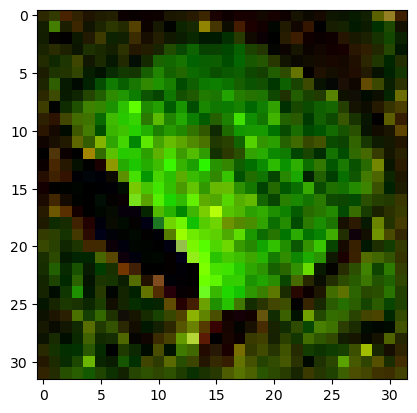

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

prompts=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'ship', 'truck', 'frog']

for prompt in prompts:
    seed = 1
    generator = torch.Generator(device="cuda").manual_seed(seed)

    save_path = "generated_images/"+str(seed)+"/"+prompt+"/"
    os.makedirs(save_path, exist_ok=True)

    image = pipe(
        height=32,
        width=32,
        prompt=prompt,
        generator=generator,
    ).images[0]

    plt.imshow(image)

    image.save(save_path+prompt+".png")

Now generate attributions using cosine similarity on the DINOV2 feature maps

In [5]:
from transformers import AutoImageProcessor, Dinov2Model

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

model = Dinov2Model.from_pretrained("facebook/dinov2-base")

input_image = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**input_image)

last_hidden_state = outputs.last_hidden_state

last_hidden_state = last_hidden_state.reshape(1,257*768)

print(last_hidden_state.shape)
print(dino_cifar10.shape)

cosine_similarity = torch.nn.CosineSimilarity(dim=1)

c = torch.zeros(1,50000)

set_size = 1000
dataset_size = 50000

for i in range(0,dataset_size//set_size):
    a=i*set_size
    b=(i+1)*set_size

    c[0,a:b] = cosine_similarity(last_hidden_state,dino_cifar10[a:b])

print(c.shape)
print(c)
print(torch.argmax(c))

torch.Size([1, 197376])
torch.Size([50000, 197376])
torch.Size([1, 50000])
tensor([[0.0567, 0.2136, 0.1224,  ..., 0.0891, 0.1136, 0.0931]])
tensor(18820)


In [6]:
del dino_cifar10

from datasets import load_dataset

#https://huggingface.co/datasets/

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

dataset = dataset.rename_column("img", "image")

tensor([18820, 42729, 46721, 33561, 24547, 35141, 40117, 12343,  8298, 10146])


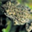

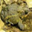

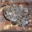

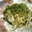

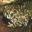

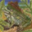

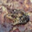

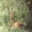

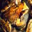

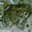

In [7]:
best_matches = torch.flatten(torch.topk(c,10).indices)
print(best_matches)

for i in range(10):
    display(dataset["image"][best_matches[i]])